In [1]:
!pip install unsloth

!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2024.11.10
Uninstalling unsloth-2024.11.10:
  Successfully uninstalled unsloth-2024.11.10
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-_hm088hb/unsloth_baa29f065e504d158c8a510eea4a7b5b
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-_hm088hb/unsloth_baa29f065e504d158c8a510eea4a7b5b
  Resolved https://github.com/unslothai/unsloth.git to commit 8558bc92b06f9128499484ef737fa71b966ffc23
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.11.10-py3-none-any.whl size=166794 sha256=a3bdaf7d6131f8e9b556c199d0cffb7cb590bd9c6b3efa40c9f5d844d3aeb172
  Stored in directory: /tmp/pip-ephem-wheel-cache-l1435xu6/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth


In [2]:
#Data Handling and Visualization
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
#LLM model training
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/fozle/Projects/Personalized-LLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
#Calling the dataset
data = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)
data  = data.head(1000)
# data

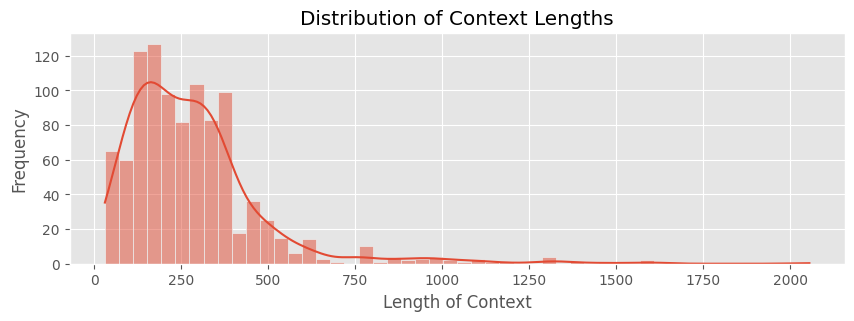

In [5]:
data['Context_length'] = data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


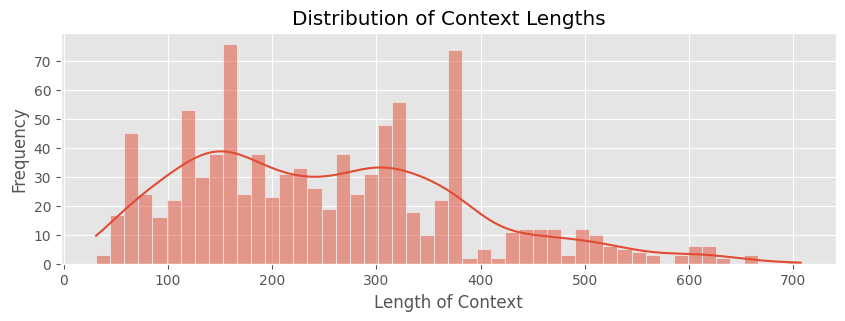

In [6]:
filtered_data = data[data['Context_length'] <= 750]

ln_Context = filtered_data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


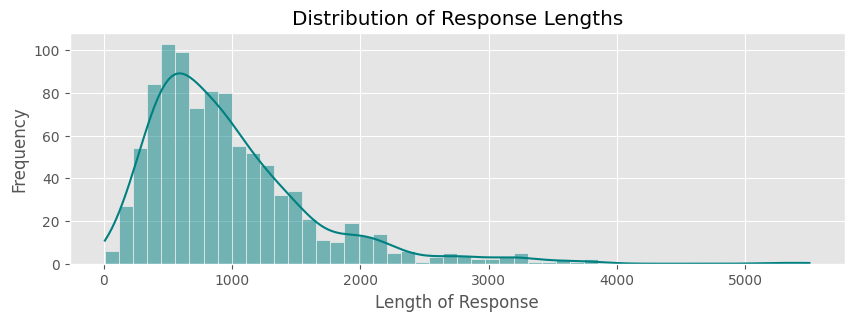

In [7]:
#Lets check now the length of words in each Response
ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


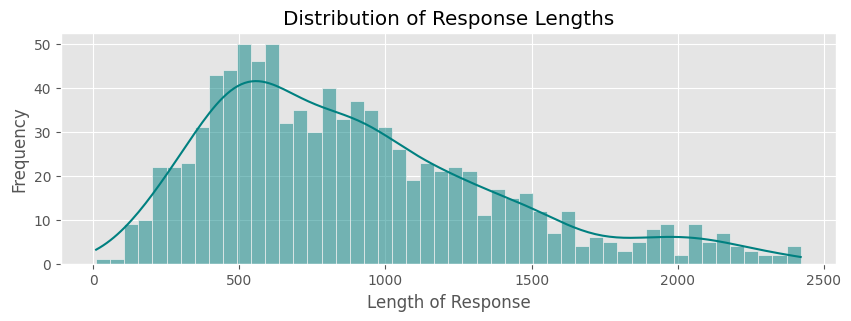

In [8]:
filtered_data = filtered_data[ln_Response <= 2500]

ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

In [9]:

# Clear existing GPU memory
torch.cuda.empty_cache()

max_seq_length = 2500
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.61 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.11.10 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [10]:
data_prompt = """Analyze the provided text from a mental health perspective. Identify any indicators of emotional distress, coping mechanisms, or psychological well-being. Highlight any potential concerns or positive aspects related to mental health, and provide a brief explanation for each observation.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Context"]
    outputs      = examples["Response"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [11]:
#Format the data for training
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)

Map: 100%|██████████| 925/925 [00:00<00:00, 137535.23 examples/s]


In [12]:

#Training Process
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=16,
        gradient_accumulation_steps=8,
        num_train_epochs=40,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 111 | Num Epochs = 40
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 8
\        /    Total batch size = 128 | Total steps = 40
 "-____-"     Number of trainable parameters = 11,272,192
  2%|▎         | 1/40 [00:24<16:06, 24.77s/it]

{'loss': 2.3448, 'grad_norm': 0.9599367380142212, 'learning_rate': 2.9999999999999997e-05, 'epoch': 1.0}


  5%|▌         | 2/40 [00:28<07:52, 12.42s/it]

{'loss': 0.3385, 'grad_norm': 0.1463918536901474, 'learning_rate': 5.9999999999999995e-05, 'epoch': 1.14}


  8%|▊         | 3/40 [00:48<09:55, 16.08s/it]

{'loss': 2.0003, 'grad_norm': 0.7832191586494446, 'learning_rate': 8.999999999999999e-05, 'epoch': 2.0}


 10%|█         | 4/40 [00:55<07:30, 12.50s/it]

{'loss': 0.6652, 'grad_norm': 0.24560341238975525, 'learning_rate': 0.00011999999999999999, 'epoch': 2.29}


 12%|█▎        | 5/40 [01:13<08:16, 14.18s/it]

{'loss': 1.5934, 'grad_norm': 0.3264631927013397, 'learning_rate': 0.00015, 'epoch': 3.0}


 15%|█▌        | 6/40 [01:23<07:18, 12.90s/it]

{'loss': 0.9594, 'grad_norm': 0.315600723028183, 'learning_rate': 0.00017999999999999998, 'epoch': 3.43}


 18%|█▊        | 7/40 [01:37<07:11, 13.07s/it]

{'loss': 1.2535, 'grad_norm': 0.41050925850868225, 'learning_rate': 0.00020999999999999998, 'epoch': 4.0}


 20%|██        | 8/40 [01:50<07:05, 13.31s/it]

{'loss': 1.2463, 'grad_norm': 0.3034920394420624, 'learning_rate': 0.00023999999999999998, 'epoch': 4.57}


 22%|██▎       | 9/40 [02:00<06:20, 12.29s/it]

{'loss': 0.903, 'grad_norm': 0.19993574917316437, 'learning_rate': 0.00027, 'epoch': 5.0}


 25%|██▌       | 10/40 [02:18<06:54, 13.82s/it]

{'loss': 1.5251, 'grad_norm': 0.301628053188324, 'learning_rate': 0.0003, 'epoch': 5.71}


 28%|██▊       | 11/40 [02:24<05:36, 11.61s/it]

{'loss': 0.5721, 'grad_norm': 0.12759850919246674, 'learning_rate': 0.00029, 'epoch': 6.0}


 30%|███       | 12/40 [02:45<06:42, 14.38s/it]

{'loss': 1.7781, 'grad_norm': 0.4451914429664612, 'learning_rate': 0.00028, 'epoch': 6.86}


 32%|███▎      | 13/40 [02:48<04:56, 11.00s/it]

{'loss': 0.2764, 'grad_norm': 0.04837000370025635, 'learning_rate': 0.00027, 'epoch': 7.0}


 35%|███▌      | 14/40 [03:12<06:27, 14.89s/it]

{'loss': 2.0078, 'grad_norm': 0.35564735531806946, 'learning_rate': 0.00026, 'epoch': 8.0}


 38%|███▊      | 15/40 [03:36<07:21, 17.66s/it]

{'loss': 1.9816, 'grad_norm': 0.24199560284614563, 'learning_rate': 0.00025, 'epoch': 9.0}


 40%|████      | 16/40 [03:40<05:21, 13.41s/it]

{'loss': 0.2843, 'grad_norm': 0.05213788151741028, 'learning_rate': 0.00023999999999999998, 'epoch': 9.14}


 42%|████▎     | 17/40 [04:00<05:58, 15.58s/it]

{'loss': 1.6663, 'grad_norm': 0.4776933789253235, 'learning_rate': 0.00023, 'epoch': 10.0}


 45%|████▌     | 18/40 [04:07<04:47, 13.05s/it]

{'loss': 0.5527, 'grad_norm': 0.08682997524738312, 'learning_rate': 0.00021999999999999995, 'epoch': 10.29}


 48%|████▊     | 19/40 [04:24<04:58, 14.22s/it]

{'loss': 1.3565, 'grad_norm': 0.18009251356124878, 'learning_rate': 0.00020999999999999998, 'epoch': 11.0}


 50%|█████     | 20/40 [04:35<04:21, 13.09s/it]

{'loss': 0.8129, 'grad_norm': 0.12167831510305405, 'learning_rate': 0.00019999999999999998, 'epoch': 11.43}


 52%|█████▎    | 21/40 [04:49<04:12, 13.28s/it]

{'loss': 1.0639, 'grad_norm': 0.15089933574199677, 'learning_rate': 0.00018999999999999998, 'epoch': 12.0}


 55%|█████▌    | 22/40 [05:02<04:02, 13.45s/it]

{'loss': 1.0679, 'grad_norm': 0.15185675024986267, 'learning_rate': 0.00017999999999999998, 'epoch': 12.57}


 57%|█████▊    | 23/40 [05:13<03:31, 12.45s/it]

{'loss': 0.7772, 'grad_norm': 0.1202634871006012, 'learning_rate': 0.00016999999999999999, 'epoch': 13.0}


 60%|██████    | 24/40 [05:30<03:41, 13.83s/it]

{'loss': 1.3097, 'grad_norm': 0.19955678284168243, 'learning_rate': 0.00015999999999999999, 'epoch': 13.71}


 62%|██████▎   | 25/40 [05:36<02:54, 11.65s/it]

{'loss': 0.5037, 'grad_norm': 0.08899524062871933, 'learning_rate': 0.00015, 'epoch': 14.0}


 65%|██████▌   | 26/40 [05:57<03:20, 14.29s/it]

{'loss': 1.5447, 'grad_norm': 0.2268078327178955, 'learning_rate': 0.00014, 'epoch': 14.86}


 68%|██████▊   | 27/40 [06:00<02:22, 10.97s/it]

{'loss': 0.2378, 'grad_norm': 0.05496347323060036, 'learning_rate': 0.00013, 'epoch': 15.0}


 70%|███████   | 28/40 [06:23<02:57, 14.76s/it]

{'loss': 1.7538, 'grad_norm': 0.23372043669223785, 'learning_rate': 0.00011999999999999999, 'epoch': 16.0}


 72%|███████▎  | 29/40 [06:47<03:11, 17.40s/it]

{'loss': 1.7389, 'grad_norm': 0.2234450876712799, 'learning_rate': 0.00010999999999999998, 'epoch': 17.0}


 75%|███████▌  | 30/40 [06:50<02:12, 13.24s/it]

{'loss': 0.2508, 'grad_norm': 0.05534961447119713, 'learning_rate': 9.999999999999999e-05, 'epoch': 17.14}


 78%|███████▊  | 31/40 [07:11<02:18, 15.36s/it]

{'loss': 1.4625, 'grad_norm': 0.2623140513896942, 'learning_rate': 8.999999999999999e-05, 'epoch': 18.0}


 80%|████████  | 32/40 [07:18<01:42, 12.85s/it]

{'loss': 0.4919, 'grad_norm': 0.10343821346759796, 'learning_rate': 7.999999999999999e-05, 'epoch': 18.29}


 82%|████████▎ | 33/40 [07:35<01:38, 14.08s/it]

{'loss': 1.2009, 'grad_norm': 0.24146221578121185, 'learning_rate': 7e-05, 'epoch': 19.0}


 85%|████████▌ | 34/40 [07:45<01:17, 12.84s/it]

{'loss': 0.7195, 'grad_norm': 0.12302105873823166, 'learning_rate': 5.9999999999999995e-05, 'epoch': 19.43}


 88%|████████▊ | 35/40 [07:58<01:04, 12.91s/it]

{'loss': 0.9539, 'grad_norm': 0.19658856093883514, 'learning_rate': 4.9999999999999996e-05, 'epoch': 20.0}


 90%|█████████ | 36/40 [08:11<00:51, 12.99s/it]

{'loss': 0.968, 'grad_norm': 0.23174162209033966, 'learning_rate': 3.9999999999999996e-05, 'epoch': 20.57}


 92%|█████████▎| 37/40 [08:20<00:35, 11.91s/it]

{'loss': 0.6908, 'grad_norm': 0.11748912930488586, 'learning_rate': 2.9999999999999997e-05, 'epoch': 21.0}


 95%|█████████▌| 38/40 [08:36<00:26, 13.14s/it]

{'loss': 1.1954, 'grad_norm': 0.19268172979354858, 'learning_rate': 1.9999999999999998e-05, 'epoch': 21.71}


 98%|█████████▊| 39/40 [08:43<00:11, 11.11s/it]

{'loss': 0.4529, 'grad_norm': 0.09810493141412735, 'learning_rate': 9.999999999999999e-06, 'epoch': 22.0}


100%|██████████| 40/40 [09:03<00:00, 14.00s/it]

{'loss': 1.4185, 'grad_norm': 0.2203027904033661, 'learning_rate': 0.0, 'epoch': 22.86}


100%|██████████| 40/40 [09:07<00:00, 13.69s/it]

{'train_runtime': 547.4264, 'train_samples_per_second': 8.111, 'train_steps_per_second': 0.073, 'train_loss': 1.098023147881031, 'epoch': 22.86}


TrainOutput(global_step=40, training_loss=1.098023147881031, metrics={'train_runtime': 547.4264, 'train_samples_per_second': 8.111, 'train_steps_per_second': 0.073, 'total_flos': 3.747680483328e+16, 'train_loss': 1.098023147881031, 'epoch': 22.857142857142858})

In [13]:
# Inference
text="I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?"


model = FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    data_prompt.format(
        #instructions
        text,
        #answer
        "",
    )
], return_tensors = "pt").to("cuda")

# Only change these parameters
outputs = model.generate(
    **inputs,
    max_new_tokens=300,          # Increased from 100
    temperature=0.7,             # Add temperature
    # num_beams=2,                # Simple beam search
    early_stopping=True         # Enable early stopping
)
answer=tokenizer.batch_decode(outputs)
answer = answer[0].split("### Response:")[-1]
formatted_answer = "\n".join(answer.split(". "))  # Split on periods and join with newlines
print("\nFormatted Answer:")
print(formatted_answer)



Formatted Answer:

I'm glad you are reaching out for help.  Suicide is a very serious issue and it is important to get help as soon as possible.  I would suggest that you find a therapist who specializes in working with people who have suicidal thoughts.  You can find a therapist in your area by visiting the website of the American Association of Professional Counselors at www.aapc.org.  You can also call the National Suicide Prevention Lifeline at 1-800-273-8255.  The National Suicide Prevention Lifeline is a free, confidential service that is available 24 hours a day, 7 days a week.  The National Suicide Prevention Lifeline can connect you with a local crisis counselor who can help you find the right help.  I hope this information is helpful to you.  Best of luck to you.<|end_of_text|>


In [ ]:
# Saving the model locally
model.save_pretrained("model/1B_finetuned_llama3.2")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2")

('model/1B_finetuned_llama3.2/tokenizer_config.json',
 'model/1B_finetuned_llama3.2/special_tokens_map.json',
 'model/1B_finetuned_llama3.2/tokenizer.json')

In [ ]:
# load the local model
model, tokenizer = FastLanguageModel.from_pretrained(
model_name = "model/1B_finetuned_llama3.2",
max_seq_length = 5020,
dtype = None,
load_in_4bit = True)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.635 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor